+---------------+-------------------+
|dropoff_borough|      avg_idle_time|
+---------------+-------------------+
|           NULL| 0.2772108962055013|
|              5|0.29166666666666663|
|              1| 0.6166666666666667|
|              4| 0.4779035517214574|
+---------------+-------------------+



Number of trips within the same borough: 912
Number of trips across different boroughs: 2


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


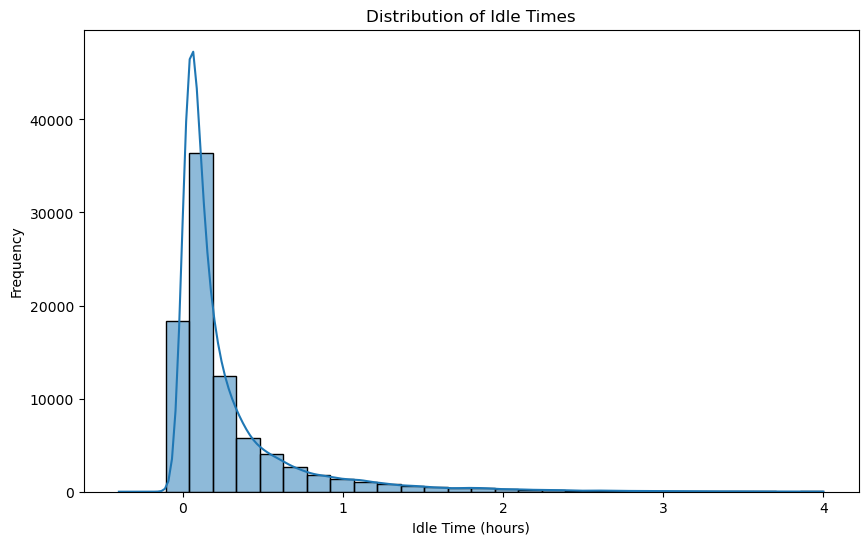

In [7]:
from pyspark.sql import SparkSession
import geopandas as gpd
from shapely.geometry import shape, Point
from pyspark.sql.functions import udf, unix_timestamp, col, lag, sum as spark_sum, avg
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("NYC Taxi Analysis").getOrCreate()

# Read data
df = spark.read.csv('./sample.csv', header=True, inferSchema=True)

# Load and process GeoJSON data
gdf = gpd.read_file('./nyc-boroughs.geojson')
gdf['geometry'] = gdf['geometry'].apply(lambda x: x if x.is_valid else x.buffer(0))

# Broadcast borough data
boroughs = gdf.apply(lambda row: (row['boroughCode'], shape(row['geometry'])), axis=1)
borough_dict = {code: geom for code, geom in boroughs}
boroughs_broadcast = spark.sparkContext.broadcast(borough_dict)

# Define UDF for getting borough from coordinates
def get_borough(longitude, latitude):
    point = Point(longitude, latitude)
    for code, geom in boroughs_broadcast.value.items():
        if geom.contains(point):
            return code
    return None

get_borough_udf = udf(get_borough)

# Enrich DataFrame with borough information
df = df.withColumn("pickup_borough", get_borough_udf(df["pickup_longitude"], df["pickup_latitude"]))
df = df.withColumn("dropoff_borough", get_borough_udf(df["dropoff_longitude"], df["dropoff_latitude"]))

# Process timestamps and calculate durations
df = df.withColumn("pickup_ts", unix_timestamp("pickup_datetime"))
df = df.withColumn("dropoff_ts", unix_timestamp("dropoff_datetime"))
df = df.withColumn("duration", (col("dropoff_ts") - col("pickup_ts")) / 3600)
df = df.filter((col("duration") > 0) & (col("duration") <= 4))

# Calculate idle time using window functions
windowSpec = Window.partitionBy("hack_license").orderBy("pickup_ts")
df = df.withColumn("previous_dropoff_ts", lag("dropoff_ts").over(windowSpec))
df = df.withColumn("idle_time", (col("pickup_ts") - col("previous_dropoff_ts")) / 3600)
df = df.filter(col("idle_time") <= 4)

# Compute utilization
utilization = df.groupBy("hack_license").agg(
    (1 - (spark_sum("idle_time") / spark_sum("duration"))).alias("utilization")
)

# Compute average time to next fare per borough
avg_time_to_next_fare = df.groupBy("dropoff_borough").agg(avg("idle_time").alias("avg_idle_time"))

# Show the average idle time per dropoff borough
avg_time_to_next_fare.show()

# Compute trip counts
same_borough_trips = df.filter(col("pickup_borough") == col("dropoff_borough")).count()
different_borough_trips = df.filter(col("pickup_borough") != col("dropoff_borough")).count()

# Print the number of trips within the same borough and across different boroughs
print(f"Number of trips within the same borough: {same_borough_trips}")
print(f"Number of trips across different boroughs: {different_borough_trips}")

# Convert to Pandas DataFrame for plotting
pandas_df = df.select("idle_time").toPandas()

# Replace inf/-inf with NaN
pandas_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['idle_time'].dropna(), bins=30, kde=True)
plt.title('Distribution of Idle Times')
plt.xlabel('Idle Time (hours)')
plt.ylabel('Frequency')
plt.show()

In [10]:
from pyspark.sql import SparkSession
import geopandas as gpd
from shapely.geometry import shape, Point
from pyspark.sql.functions import udf, unix_timestamp, col, lag, sum as spark_sum, avg, trim
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Initialize Spark session
spark = SparkSession.builder.appName("NYC Taxi Analysis").getOrCreate()

# Function to trim column names
def trim_columns(df):
    for col_name in df.columns:
        df = df.withColumnRenamed(col_name, col_name.strip())
    return df

# Read trip data
trip_data_df = spark.read.csv('trip_data/*.csv', header=True, inferSchema=True)
trip_data_df = trim_columns(trip_data_df)

# Read trip fare data
trip_fare_df = spark.read.csv('trip_fare/*.csv', header=True, inferSchema=True)
trip_fare_df = trim_columns(trip_fare_df)

# Join trip data and fare data on 'medallion' and 'hack_license'
df = trip_data_df.alias('td').join(trip_fare_df.alias('tf'), ['medallion', 'hack_license'])

# Load and process GeoJSON data
gdf = gpd.read_file('./nyc-boroughs.geojson')
gdf['geometry'] = gdf['geometry'].apply(lambda x: x if x.is_valid else x.buffer(0))

# Broadcast borough data
boroughs = gdf.apply(lambda row: (row['boroughCode'], shape(row['geometry'])), axis=1)
borough_dict = {code: geom for code, geom in boroughs}
boroughs_broadcast = spark.sparkContext.broadcast(borough_dict)

# Define UDF for getting borough from coordinates
def get_borough(longitude, latitude):
    point = Point(longitude, latitude)
    for code, geom in boroughs_broadcast.value.items():
        if geom.contains(point):
            return code
    return None

get_borough_udf = udf(get_borough)

# Enrich DataFrame with borough information
df = df.withColumn("pickup_borough", get_borough_udf(df["td.pickup_longitude"], df["td.pickup_latitude"]))
df = df.withColumn("dropoff_borough", get_borough_udf(df["td.dropoff_longitude"], df["td.dropoff_latitude"]))

# Process timestamps and calculate durations
df = df.withColumn("pickup_ts", unix_timestamp(df["td.pickup_datetime"]))
df = df.withColumn("dropoff_ts", unix_timestamp(df["td.dropoff_datetime"]))
df = df.withColumn("duration", (col("dropoff_ts") - col("pickup_ts")) / 3600)
df = df.filter((col("duration") > 0) & (col("duration") <= 4))

# Calculate idle time using window functions
windowSpec = Window.partitionBy("hack_license").orderBy("pickup_ts")
df = df.withColumn("previous_dropoff_ts", lag("dropoff_ts").over(windowSpec))
df = df.withColumn("idle_time", (col("pickup_ts") - col("previous_dropoff_ts")) / 3600)
df = df.filter(col("idle_time") <= 4)

# Compute utilization
utilization = df.groupBy("hack_license").agg(
    (1 - (spark_sum("idle_time") / spark_sum("duration"))).alias("utilization")
)

# Compute average time to next fare per borough
avg_time_to_next_fare = df.groupBy("dropoff_borough").agg(avg("idle_time").alias("avg_idle_time"))

# Show the average idle time per dropoff borough
avg_time_to_next_fare.show()

# Compute trip counts
same_borough_trips = df.filter(col("pickup_borough") == col("dropoff_borough")).count()
different_borough_trips = df.filter(col("pickup_borough") != col("dropoff_borough")).count()

# Print the number of trips within the same borough and across different boroughs
print(f"Number of trips within the same borough: {same_borough_trips}")
print(f"Number of trips across different boroughs: {different_borough_trips}")

# Convert to Pandas DataFrame for plotting
pandas_df = df.select("idle_time").toPandas()

# Replace inf/-inf with NaN
pandas_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['idle_time'].dropna(), bins=30, kde=True)
plt.title('Distribution of Idle Times')
plt.xlabel('Idle Time (hours)')
plt.ylabel('Frequency')
plt.show()

24/06/05 19:55:26 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: medallion,  hack_license,  pickup_datetime,  dropoff_datetime,  dropoff_longitude,  dropoff_latitude
 Schema: medallion, hack_license, pickup_datetime, dropoff_datetime, dropoff_longitude, dropoff_latitude
Expected: hack_license but found:  hack_license
CSV file: file:///Users/lanxiangzhang/Desktop/Big%20Data%20Management/Projects/Big-Data-Management-Projects/Analysing%20New%20York%20City%20Taxi%20Data%20with%20Spark/trip_data/trip_data_10.csv
24/06/05 19:55:39 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: medallion,  hack_license,  pickup_datetime,  dropoff_datetime,  dropoff_longitude,  dropoff_latitude
 Schema: medallion, hack_license, pickup_datetime, dropoff_datetime, dropoff_longitude, dropoff_latitude
Expected: hack_license but found:  hack_license
CSV file: file:///Users/lanxiangzhang/Desktop/Big%20Data%20Management/Projects/Big-Data-Management-Projects/Anal

24/06/05 19:58:02 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/0d/temp_shuffle_5e889c8a-0b09-41e6-b8ef-4a95a43dfe4e, No space left on device
24/06/05 19:58:02 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/25/temp_shuffle_94cbe954-95a0-45b4-8595-27ea3567e230, No space left on device
24/06/05 19:58:02 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/2a/temp_shuffle_4fed0afd-090a-46f3-8579-0bd4517a6849, No space left on device
24/06/05 19:58:02 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /priv

24/06/05 19:58:02 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/3b/temp_shuffle_66eb122c-9a65-4817-a77f-2489d8ed03e3, No space left on device
24/06/05 19:58:02 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/03/temp_shuffle_182c176a-6372-4d50-b935-bb632ad48d45, No space left on device
24/06/05 19:58:03 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/38/temp_shuffle_2a6c4001-2be6-4a38-9779-c0996d15975e, No space left on device
24/06/05 19:58:03 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /priv

24/06/05 19:58:03 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/13/temp_shuffle_04818fa8-fd88-4fcf-af74-3e0a8c788570, No space left on device
24/06/05 19:58:03 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/00/temp_shuffle_b9702138-3093-474c-86bc-d58d844ebfc4, No space left on device
24/06/05 19:58:03 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/0c/temp_shuffle_1e7c3382-8681-43a7-81b8-ef0703420933, No space left on device
24/06/05 19:58:03 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /priv

24/06/05 19:58:04 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/2f/temp_shuffle_a2ac1d39-7d65-4ac3-8250-9a0b4cef1a73, No space left on device
24/06/05 19:58:04 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/0b/temp_shuffle_78aef73a-4584-4b69-92ed-54020548a474, No space left on device
24/06/05 19:58:04 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/25/temp_shuffle_370006c3-239f-4691-a0e4-0ad509f358f7, No space left on device
24/06/05 19:58:04 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /priv

24/06/05 19:58:05 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/39/temp_shuffle_32c2f837-d1b5-4415-afc8-10026330bffa, No space left on device
24/06/05 19:58:05 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/30/temp_shuffle_93a03734-7c6b-4be1-b5df-06802361fbf4, No space left on device
24/06/05 19:58:05 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/2f/temp_shuffle_ece49c58-8d4b-4d95-8e84-cb22ffb36f72, No space left on device
24/06/05 19:58:05 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /priv

24/06/05 19:58:06 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/06/temp_shuffle_e06c8321-d7db-4152-8ca3-b85745d200c3, No space left on device
24/06/05 19:58:06 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/0d/temp_shuffle_72461677-e6a0-4a33-99bb-0ecb6e55655f, No space left on device
24/06/05 19:58:06 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /private/var/folders/7t/7t_st__d45b93zl8rkqpnsw40000gn/T/blockmgr-f50fa479-4683-4e84-ad1a-108fe7a1af5b/39/temp_shuffle_e00ac85d-3e33-4c82-900a-3702c84f4273, No space left on device
24/06/05 19:58:06 ERROR DiskBlockObjectWriter: Exception occurred while manually close the output stream to file /priv

24/06/05 19:58:10 ERROR Executor: Exception in task 148.0 in stage 128.0 (TID 1421)
java.io.IOException: No space left on device
	at java.base/sun.nio.ch.UnixFileDispatcherImpl.write0(Native Method)
	at java.base/sun.nio.ch.UnixFileDispatcherImpl.write(UnixFileDispatcherImpl.java:65)
	at java.base/sun.nio.ch.IOUtil.writeFromNativeBuffer(IOUtil.java:137)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:81)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:72)
	at java.base/sun.nio.ch.FileChannelImpl.write(FileChannelImpl.java:300)
	at java.base/sun.nio.ch.FileChannelImpl.transferToTrustedChannel(FileChannelImpl.java:679)
	at java.base/sun.nio.ch.FileChannelImpl.transferTo(FileChannelImpl.java:782)
	at org.apache.spark.util.Utils$.copyFileStreamNIO(Utils.scala:346)
	at org.apache.spark.util.Utils.copyFileStreamNIO(Utils.scala)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.writePartitionedDataWithChannel(BypassMergeSortShuffleWriter.java:246)
	at org.apache.spark.shuffle

Py4JJavaError: An error occurred while calling o939.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 148 in stage 128.0 failed 1 times, most recent failure: Lost task 148.0 in stage 128.0 (TID 1421) (lanxiangdembp.lan executor driver): java.io.IOException: No space left on device
	at java.base/sun.nio.ch.UnixFileDispatcherImpl.write0(Native Method)
	at java.base/sun.nio.ch.UnixFileDispatcherImpl.write(UnixFileDispatcherImpl.java:65)
	at java.base/sun.nio.ch.IOUtil.writeFromNativeBuffer(IOUtil.java:137)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:81)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:72)
	at java.base/sun.nio.ch.FileChannelImpl.write(FileChannelImpl.java:300)
	at java.base/sun.nio.ch.FileChannelImpl.transferToTrustedChannel(FileChannelImpl.java:679)
	at java.base/sun.nio.ch.FileChannelImpl.transferTo(FileChannelImpl.java:782)
	at org.apache.spark.util.Utils$.copyFileStreamNIO(Utils.scala:346)
	at org.apache.spark.util.Utils.copyFileStreamNIO(Utils.scala)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.writePartitionedDataWithChannel(BypassMergeSortShuffleWriter.java:246)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.writePartitionedData(BypassMergeSortShuffleWriter.java:218)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:180)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.io.IOException: No space left on device
	at java.base/sun.nio.ch.UnixFileDispatcherImpl.write0(Native Method)
	at java.base/sun.nio.ch.UnixFileDispatcherImpl.write(UnixFileDispatcherImpl.java:65)
	at java.base/sun.nio.ch.IOUtil.writeFromNativeBuffer(IOUtil.java:137)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:81)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:72)
	at java.base/sun.nio.ch.FileChannelImpl.write(FileChannelImpl.java:300)
	at java.base/sun.nio.ch.FileChannelImpl.transferToTrustedChannel(FileChannelImpl.java:679)
	at java.base/sun.nio.ch.FileChannelImpl.transferTo(FileChannelImpl.java:782)
	at org.apache.spark.util.Utils$.copyFileStreamNIO(Utils.scala:346)
	at org.apache.spark.util.Utils.copyFileStreamNIO(Utils.scala)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.writePartitionedDataWithChannel(BypassMergeSortShuffleWriter.java:246)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.writePartitionedData(BypassMergeSortShuffleWriter.java:218)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:180)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1583)


24/06/05 19:58:10 WARN TaskSetManager: Lost task 154.0 in stage 128.0 (TID 1427) (lanxiangdembp.lan executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Task 148 in stage 128.0 failed 1 times, most recent failure: Lost task 148.0 in stage 128.0 (TID 1421) (lanxiangdembp.lan executor driver): java.io.IOException: No space left on device
	at java.base/sun.nio.ch.UnixFileDispatcherImpl.write0(Native Method)
	at java.base/sun.nio.ch.UnixFileDispatcherImpl.write(UnixFileDispatcherImpl.java:65)
	at java.base/sun.nio.ch.IOUtil.writeFromNativeBuffer(IOUtil.java:137)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:81)
	at java.base/sun.nio.ch.IOUtil.write(IOUtil.java:72)
	at java.base/sun.nio.ch.FileChannelImpl.write(FileChannelImpl.java:300)
	at java.base/sun.nio.ch.FileChannelImpl.transferToTrustedChannel(FileChannelImpl.java:679)
	at java.base/sun.nio.ch.FileChannelImpl.transferTo(FileChannelImpl.java:782)
	at org.apache.spark.util.Utils$.copyFileStreamNIO(Utils